# Reference:

This notebook includes concepts and code adapted from the GAIN (Generative Adversarial Imputation Nets) project by Jinsung Yoon et al. The GAIN approach is utilized here for imputing missing values in datasets. For more details, visit the [GAIN GitHub repository](https://github.com/jsyoon0823/GAIN).

Original Paper: J. Yoon, J. Jordon, M. van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets," ICML, 2018.

In [1]:
#importing Libraries
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

2024-02-22 13:33:20.445545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 13:33:20.963018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#setting up random seeds for reproducibility
tf.random.set_seed(6688)
random.seed(6688)
np.random.seed(6688)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        raise e

2024-02-22 13:33:21.502156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:21.502396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:21.502600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# necessary packages
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## The following functions are adapted from the GAIN project by Jinsung Yoon et al.
### See: https://github.com/jsyoon0823/GAIN for the original implementation.

In [5]:
def rounding(imputed_data, data_x):
    '''Round imputed data for categorical variables.
  
    Args:
    - imputed_data: imputed data
    - data_x: original data with missing values
    
    Returns:
    - rounded_data: rounded imputed data
    '''
    
    _, dim = data_x.shape
    rounded_data = imputed_data.copy()
  
    for i in range(dim):
        temp = data_x[~np.isnan(data_x[:, i]), i]
        # Only for the categorical variable
        if len(np.unique(temp)) < 20:
            rounded_data[:, i] = np.round(rounded_data[:, i])
            
    return rounded_data

In [6]:
def rmse_loss(ori_data, imputed_data, data_m):
    
    '''Compute RMSE loss between ori_data and imputed_data
  
    Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
    Returns:
    - rmse: Root Mean Squared Error
    '''
    
    #ori_data, norm_parameters = normalization(ori_data)
    #imputed_data, _ = normalization(imputed_data, norm_parameters)
    
    # Only for missing values
    nominator = np.sum(((1-data_m) * ori_data - (1-data_m) * imputed_data)**2)
    denominator = np.sum(1-data_m)
    
    rmse = np.sqrt(nominator/float(denominator))
    
    return rmse

def rmse_loss(ori_data_x, imputed_data_x, data_m):
    '''
    Args:
    - ori_data_x: original data with missing values
    - imputed_data_x: imputed data
    - data_m: missingness indicator matrix
    
    Returns:
    - rmse: Root Mean Square Error
    '''
    # Get a mask indicating where values are NOT missing in the original data
    mask = (1 - data_m).astype(bool)
    
    # Calculate the squared differences between original and imputed data
    # only at the observed (non-NaN) entries
    squared_error = (ori_data_x - imputed_data_x)**2
    
    # Calculate the mean squared error only over the observed entries
    mse = np.sum(squared_error[mask]) / np.sum(mask)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    return rmse

In [7]:
def xavier_init(size):
    '''Xavier initialization.
  
    Args:
    - size: vector size
    
    Returns:
    - initialized random vector.
    '''
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)

def binary_sampler(p, rows, cols):
    '''Sample binary random variables.
  
    Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
    Returns:
    - binary_random_matrix: generated binary random matrix.
    '''
    unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
    binary_random_matrix = 1*(unif_random_matrix < p)
    return binary_random_matrix

def uniform_sampler(low, high, rows, cols):
    '''Sample uniform random variables.
  
    Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
    Returns:
    - uniform_random_matrix: generated uniform random matrix.
    '''
    return np.random.uniform(low, high, size = [rows, cols])

In [8]:
def sample_batch_index(total, batch_size):
    '''Sample index of the mini-batch.
  
    Args:
    - total: total number of samples
    - batch_size: batch size
    
    Returns:
    - batch_idx: batch index
    '''
    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

In [9]:
# for three columns simplified gan is required

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.Session()
sess.run(tf.global_variables_initializer())


import numpy as np
from tqdm import tqdm

def gain(data_x, gain_parameters):
    '''Impute missing values in data_x

    Args:
    - data_x: original data with missing values
    - gain_parameters: GAIN network parameters:
        - batch_size: Batch size
        - hint_rate: Hint rate
        - alpha: Hyperparameter
        - iterations: Iterations

    Returns:
    - imputed_data: imputed data
    '''
    # Define mask matrix
    #data_m = 1 - np.isnan(data_x)
    
    #print(f"Inside GAIN method, data_x shape: {data_x.shape}")

    # System parameters
    batch_size = gain_parameters['batch_size']
    hint_rate = gain_parameters['hint_rate']
    alpha = gain_parameters['alpha']
    iterations = gain_parameters['iterations']

    # Other parameters
    no, dim = data_x.shape

    # Hidden state dimensions
    h_dim = int(dim)
    
    # Fill NaN values with 0
    norm_data_x = np.nan_to_num(data_x, 0)

    
    ## GAIN architecture
    # Input placeholders
    # Data vector
    X = tf.placeholder(tf.float32, shape=[None, dim])
    # Mask vector
    M = tf.placeholder(tf.float32, shape=[None, dim])
    # Hint vector
    H = tf.placeholder(tf.float32, shape=[None, dim])

    # Discriminator variables
    D_W1 = tf.Variable(xavier_init([dim * 2, h_dim]))  # Data + Hint as inputs
    D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
    D_W2 = tf.Variable(xavier_init([h_dim, dim]))
    D_b2 = tf.Variable(tf.zeros(shape=[dim]))  # Multi-variate outputs
    theta_D = [D_W1, D_W2, D_b1, D_b2]

    # Generator variables
    # Data + Mask as inputs (Random noise is in missing components)
    # Data + Mask as inputs (Random noise is in missing components)
    G_W1 = tf.Variable(xavier_init([dim * 2, h_dim]))
    G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
    G_W2 = tf.Variable(xavier_init([h_dim, dim]))
    G_b2 = tf.Variable(tf.zeros(shape=[dim]))

    theta_G = [G_W1, G_W2, G_b1, G_b2]

    ## GAIN functions
    # Generator
    def generator(x, m):
        # Concatenate Mask and Data
        inputs = tf.concat(values=[x, m], axis=1)
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        # MinMax normalized output
        G_prob = tf.nn.sigmoid(tf.matmul(G_h1, G_W2) + G_b2)
        return G_prob

    # Discriminator
    def discriminator(x, h):
        # Concatenate Data and Hint
        inputs = tf.concat(values=[x, h], axis=1)
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
        D_logit = tf.matmul(D_h1, D_W2) + D_b2
        D_prob = tf.nn.sigmoid(D_logit)
        return D_prob

    ## GAIN structure
    # Generator
    G_sample = generator(X, M)

    # Combine with observed data
    Hat_X = X * M + G_sample * (1 - M)

    # Discriminator
    D_prob = discriminator(Hat_X, H)

    ## GAIN loss
    D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8)
                                  + (1 - M) * tf.log(1. - D_prob + 1e-8))

    G_loss_temp = -tf.reduce_mean((1 - M) * tf.log(D_prob + 1e-8))

    MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)

    D_loss = D_loss_temp
    G_loss = G_loss_temp + alpha * MSE_loss

    ## GAIN solver
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

    ## Iterations
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # Start Iterations
    for it in tqdm(range(iterations)):

        # Sample batch
        batch_idx = sample_batch_index(no, batch_size)
        X_mb = norm_data_x[batch_idx, :]
        M_mb = data_m[batch_idx, :]
        # Sample random vectors
        Z_mb = uniform_sampler(0, 0.01, batch_size, dim)
        # Sample hint vectors
        H_mb_temp = binary_sampler(hint_rate, batch_size, dim)
        H_mb = M_mb * H_mb_temp

        # Combine random vectors with observed vectors
        X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

        _, D_loss_curr = sess.run([D_solver, D_loss_temp],
                                  feed_dict={M: M_mb, X: X_mb, H: H_mb})
        _, G_loss_curr, MSE_loss_curr = sess.run([G_solver, G_loss_temp, MSE_loss],
                                                 feed_dict={X: X_mb, M: M_mb, H: H_mb})

    ## Return imputed data
    Z_mb = uniform_sampler(0, 0.01, no, dim)
    M_mb = data_m
    X_mb = norm_data_x
    X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    imputed_data = sess.run([G_sample], feed_dict={X: X_mb, M: M_mb})[0]
    
    imputed_data = data_m * norm_data_x + (1 - data_m) * imputed_data

    # Rounding
    imputed_data = rounding(imputed_data, data_x)

    return imputed_data

2024-02-22 13:33:21.728586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:21.728808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:21.729033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
# initializing df 
df = pd.read_csv("ultimate_data.csv").drop("Unnamed: 0", axis=1)
df.drop(df[(df['location of source for water'] == 'in own dwelling') & (df['source of drinking water (simplified)'] == "sachet")].index, inplace=True)
df.drop(df[(df['location of source for water'] == 'in own yard/plot') & (df['source of drinking water (simplified)'] == "sachet")].index, inplace=True)
df.drop(df[(df['time to get to water source (minutes)'] == 0) & (df['source of drinking water (simplified)'] == "sachet")].index, inplace=True)
df.drop(df[(df['time to get to water source (minutes)'] == 0) & (df['location of source for water'] == 'elsewhere')].index, inplace=True)
#removing missing values' rows to make a complete available dataset for better training
df.dropna(subset=['source of drinking water (simplified)', 'location of source for water','time to get to water source (minutes)'],inplace=True)

In [11]:
df.isnull().sum()

source of drinking water (simplified)    0
time to get to water source (minutes)    0
location of source for water             0
dtype: int64

In [12]:
df2=df.copy()

In [13]:
# applying Min-Max scaling to the 'time' column
# scaler = MinMaxScaler()
# df[['time to get to water source (minutes)']] = scaler.fit_transform(df[['time to get to water source (minutes)']])

# defining GAIN parameters
gain_parameters = {
    'batch_size': 128,
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 100
}
# performing one-hot encoding on categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(df[['source of drinking water (simplified)', 'location of source for water']])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['source of drinking water (simplified)', 'location of source for water']))

# removing unwanted columns after one-hot encoding is needed
#encoded_df.drop(columns=['source of drinking water (simplified)_NaN', 'location of source for water_NaN'], inplace=True)

print(encoded_df)

        source of drinking water (simplified)_Tube well or borehole  \
0                                                     0.0             
1                                                     0.0             
2                                                     0.0             
3                                                     0.0             
4                                                     0.0             
...                                                   ...             
679182                                                0.0             
679183                                                0.0             
679184                                                0.0             
679185                                                0.0             
679186                                                0.0             

        source of drinking water (simplified)_bottled  \
0                                                 0.0   
1                                

In [14]:
# dropping the original columns that have been one-hot encoded
df.drop(['source of drinking water (simplified)', 'location of source for water'], axis=1, inplace=True)
# concatenating the dataframes
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
print(df)

        time to get to water source (minutes)  \
0                                        20.0   
1                                        30.0   
2                                        30.0   
3                                        30.0   
4                                        20.0   
...                                       ...   
679182                                    0.0   
679183                                    0.0   
679184                                   10.0   
679185                                    0.0   
679186                                   10.0   

        source of drinking water (simplified)_Tube well or borehole  \
0                                                     0.0             
1                                                     0.0             
2                                                     0.0             
3                                                     0.0             
4                                                     0.

In [15]:
#artificial missingness in test1 and val1
missing_r= 0.3
n = int(df.shape[0] * missing_r)
r = np.random.choice(df.index, size=n, replace=False)
for i in r:
    col_n = np.random.choice(df.columns, size=1)[0]
    df.loc[i, col_n] = np.nan
    
print('with missing values:')
print(df.head())
df1=df.copy()

with missing values:
   time to get to water source (minutes)  \
0                                    NaN   
1                                   30.0   
2                                   30.0   
3                                   30.0   
4                                   20.0   

   source of drinking water (simplified)_Tube well or borehole  \
0                                                0.0             
1                                                0.0             
2                                                0.0             
3                                                0.0             
4                                                0.0             

   source of drinking water (simplified)_bottled  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   s

In [16]:
#fillna
#df2 = df2.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df2 = df2.copy()

In [17]:
#df1.isnull().sum()

In [18]:
df1.tail(5)

,time to get to water source (minutes),source of drinking water (simplified)_Tube well or borehole,source of drinking water (simplified)_bottled,source of drinking water (simplified)_other,source of drinking water (simplified)_piped into dwelling,source of drinking water (simplified)_piped to neighbor,source of drinking water (simplified)_piped to yard/plot,source of drinking water (simplified)_protected spring,source of drinking water (simplified)_protected well,source of drinking water (simplified)_public tap/standpipe,source of drinking water (simplified)_rainwater,source of drinking water (simplified)_sachet,source of drinking water (simplified)_street vendor,source of drinking water (simplified)_surface water,source of drinking water (simplified)_unprotected spring,source of drinking water (simplified)_unprotected well,location of source for water_elsewhere,location of source for water_in own dwelling,location of source for water_in own yard/plot
679182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
679183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
679184,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
679185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
679186,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# preparing data_x and data_m before calling the gain function
data_x = df1.values
data_m = 1 - np.isnan(data_x)

In [20]:
data_x

array([[nan,  0.,  0., ...,  1.,  0.,  0.],
       [30.,  0.,  0., ...,  1.,  0.,  0.],
       [30.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [10.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [10.,  0.,  0., ...,  1.,  0.,  0.]])

In [21]:
data_m

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [22]:
# inserting print statements to check the initial shapes and types of data_x and data_m
print(f"data_x shape: {data_x.shape}, data_m shape: {data_m.shape}")
print(f"data_x type: {type(data_x)}, data_m type: {type(data_m)}")

data_x shape: (679187, 19), data_m shape: (679187, 19)
data_x type: <class 'numpy.ndarray'>, data_m type: <class 'numpy.ndarray'>


In [23]:
# dfining GAIN parameters
gain_parameters = {
    'batch_size': 128,
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 100,
}
print("NaN values per column before imputation:")
print(df1.isnull().sum())
print("After one-hot encoding:")
# calling GAIN function to get the imputed data
imputed_data = gain(data_x, gain_parameters)

NaN values per column before imputation:
time to get to water source (minutes)                          10822
source of drinking water (simplified)_Tube well or borehole    10705
source of drinking water (simplified)_bottled                  10794
source of drinking water (simplified)_other                    10653
source of drinking water (simplified)_piped into dwelling      10909
source of drinking water (simplified)_piped to neighbor        10609
source of drinking water (simplified)_piped to yard/plot       10629
source of drinking water (simplified)_protected spring         10921
source of drinking water (simplified)_protected well           10678
source of drinking water (simplified)_public tap/standpipe     10779
source of drinking water (simplified)_rainwater                10755
source of drinking water (simplified)_sachet                   10521
source of drinking water (simplified)_street vendor            10686
source of drinking water (simplified)_surface water           

2024-02-22 13:33:42.902910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:42.903216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 13:33:42.903438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [24]:
print('After Imputation :')
print(imputed_data)

After Imputation :
[[ 0.64575148  0.          0.         ...  1.          0.
   0.        ]
 [30.          0.          0.         ...  1.          0.
   0.        ]
 [30.          0.          0.         ...  1.          0.
   0.        ]
 ...
 [10.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]
 [10.          0.          0.         ...  1.          0.
   0.        ]]


In [25]:
# creating a new df from the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=df.columns)

In [26]:
print('imputed data after gain', imputed_df)
# after imputation, denormalizing the 'time to get to water source (minutes)' column is needed
#imputed_df['time to get to water source (minutes)'] = scaler.inverse_transform(imputed_df[['time to get to water source (minutes)']])

imputed data after gain         time to get to water source (minutes)  \
0                                    0.645751   
1                                   30.000000   
2                                   30.000000   
3                                   30.000000   
4                                   20.000000   
...                                       ...   
679182                               0.000000   
679183                               0.000000   
679184                              10.000000   
679185                               0.000000   
679186                              10.000000   

        source of drinking water (simplified)_Tube well or borehole  \
0                                                     0.0             
1                                                     0.0             
2                                                     0.0             
3                                                     0.0             
4                               

In [27]:
imputed_df.tail(29)

,time to get to water source (minutes),source of drinking water (simplified)_Tube well or borehole,source of drinking water (simplified)_bottled,source of drinking water (simplified)_other,source of drinking water (simplified)_piped into dwelling,source of drinking water (simplified)_piped to neighbor,source of drinking water (simplified)_piped to yard/plot,source of drinking water (simplified)_protected spring,source of drinking water (simplified)_protected well,source of drinking water (simplified)_public tap/standpipe,source of drinking water (simplified)_rainwater,source of drinking water (simplified)_sachet,source of drinking water (simplified)_street vendor,source of drinking water (simplified)_surface water,source of drinking water (simplified)_unprotected spring,source of drinking water (simplified)_unprotected well,location of source for water_elsewhere,location of source for water_in own dwelling,location of source for water_in own yard/plot
679158,15.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
679159,120.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
679160,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
679161,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
679162,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
679163,60.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
679164,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
679165,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
679166,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
679167,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# decoding the one-hot encoded columns back to their original form using the original 'encoded_df' df
imputed_df['source of drinking water (simplified)'] = encoded_df.filter(like='source of drinking water (simplified)_').idxmax(axis=1).str.split('_').str[-1]
imputed_df['location of source for water'] = encoded_df.filter(like='location of source for water_').idxmax(axis=1).str.split('_').str[-1]
# droppingp the one-hot encoded columns
imputed_df = imputed_df.drop(columns=encoded_df.columns)
print("\nAfter one-hot decoding and denormalizing:")
print(imputed_df.head())


After one-hot decoding and denormalizing:
   time to get to water source (minutes)  \
0                               0.645751   
1                              30.000000   
2                              30.000000   
3                              30.000000   
4                              20.000000   

  source of drinking water (simplified) location of source for water  
0                         surface water                    elsewhere  
1                         surface water                    elsewhere  
2                         surface water                    elsewhere  
3                         surface water                    elsewhere  
4                         surface water                    elsewhere  


In [29]:
imputed_df.head(20)

,time to get to water source (minutes),source of drinking water (simplified),location of source for water
0,0.645751,surface water,elsewhere
1,30.000000,surface water,elsewhere
2,30.000000,surface water,elsewhere
3,30.000000,surface water,elsewhere
4,20.000000,surface water,elsewhere
5,60.000000,surface water,elsewhere
6,90.000000,surface water,elsewhere
7,10.000000,surface water,elsewhere
8,20.000000,surface water,elsewhere
9,10.000000,surface water,elsewhere


In [30]:
imputed_df

,time to get to water source (minutes),source of drinking water (simplified),location of source for water
0,0.645751,surface water,elsewhere
1,30.000000,surface water,elsewhere
2,30.000000,surface water,elsewhere
3,30.000000,surface water,elsewhere
4,20.000000,surface water,elsewhere
...,...,...,...
679182,0.000000,protected well,in own yard/plot
679183,0.000000,protected well,in own yard/plot
679184,10.000000,unprotected well,elsewhere
679185,0.000000,protected well,in own yard/plot


In [31]:
#filtering the data based on specific values in two columns
mask1 = (imputed_df['time to get to water source (minutes)']== 0) & (imputed_df['location of source for water'] == "elsewhere")
filtered_data1 = imputed_df[mask1]
filtered_data1

,time to get to water source (minutes),source of drinking water (simplified),location of source for water


In [32]:
#filtering the data based on specific values in two columns
mask1 = (imputed_df['time to get to water source (minutes)']> 0) & (imputed_df['location of source for water'] == "in own dwelling")
filtered_data1 = imputed_df[mask1]
filtered_data1

,time to get to water source (minutes),source of drinking water (simplified),location of source for water
11067,0.714395,unprotected well,in own dwelling
25300,0.714529,unprotected well,in own dwelling
34514,0.678474,other,in own dwelling
35750,0.742332,public tap/standpipe,in own dwelling
37715,0.714063,unprotected well,in own dwelling
...,...,...,...
657249,0.643778,surface water,in own dwelling
666159,0.714906,Tube well or borehole,in own dwelling
671046,0.714171,unprotected well,in own dwelling
672493,0.714873,Tube well or borehole,in own dwelling


# 0.037% irrelevant results found

In [33]:
#filtering the data based on specific values in two columns
mask1 = (imputed_df['time to get to water source (minutes)']> 0) & (imputed_df['location of source for water'] == "in own yard/plot")
filtered_data1 = imputed_df[mask1]
filtered_data1

,time to get to water source (minutes),source of drinking water (simplified),location of source for water
550,0.716021,street vendor,in own yard/plot
1278,0.719700,protected well,in own yard/plot
1383,0.755641,unprotected well,in own yard/plot
1801,0.755982,unprotected well,in own yard/plot
1802,0.719644,protected well,in own yard/plot
...,...,...,...
677952,0.719400,protected well,in own yard/plot
678059,0.761506,Tube well or borehole,in own yard/plot
679095,0.761143,Tube well or borehole,in own yard/plot
679101,0.719801,protected well,in own yard/plot


# 0.12% irrelevant results found

# RMSE:

In [34]:
rmse_time = np.sqrt(np.mean((df2['time to get to water source (minutes)'] - imputed_df['time to get to water source (minutes)'])**2))
print(f"RMSE for 'time to get to water source (minutes)': {rmse_time}")

RMSE for 'time to get to water source (minutes)': 63.82126084463762


In [35]:
# necessary packages
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# plotting

/mnt/datadisk/data/Projects/pranti/newvenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


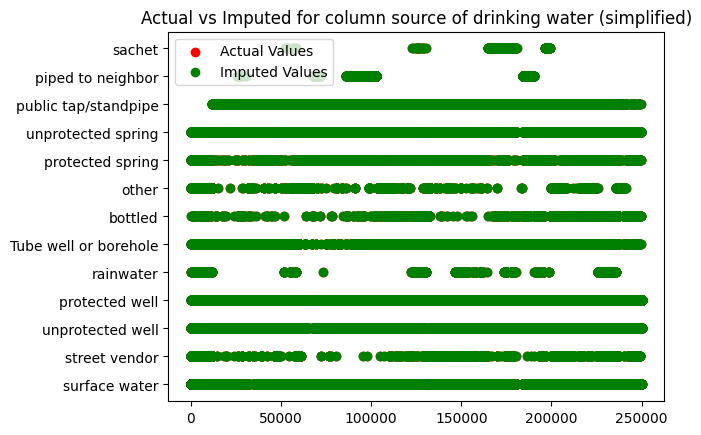

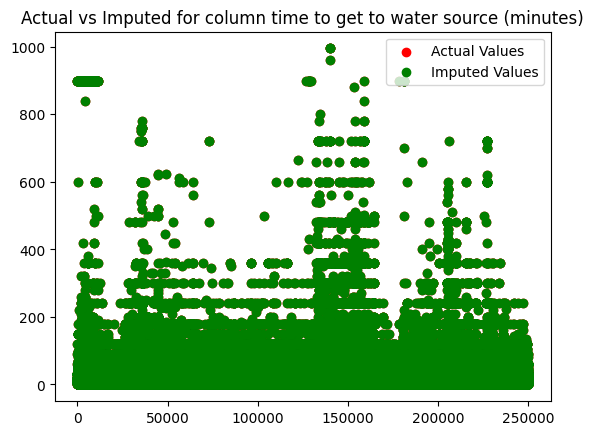

/mnt/datadisk/data/Projects/pranti/newvenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


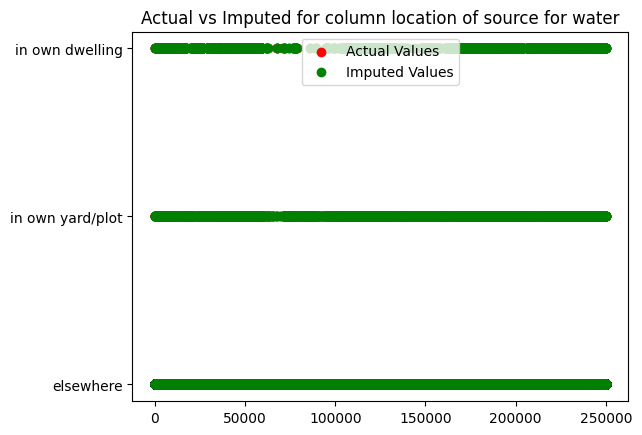

In [36]:
# listing of columns to plot
columns_to_plot = ['source of drinking water (simplified)', 'time to get to water source (minutes)', 'location of source for water']  # Replace with your actual column names

for col in columns_to_plot:
    # this creates an array of 2000 consecutive numbers, from 0 to 1999
    x_values = [i for i in range(250000)]
    # this selects the values from column 'col' of 'decoded_df' for indices 2000 to 3999
    y_actual_values = np.array(imputed_df[col])[0:250000]
    # ensuring the lists are of the same size
    assert len(x_values) == len(y_actual_values), f"Size mismatch in column {col} for actual values"
    # plotting actual values
    plt.scatter(x_values, y_actual_values, color="red")
    # for imputed values
    y_imputed_values = imputed_df[col].iloc[0:250000].values
    # ensureing the lists are of the same size
    assert len(x_values) == len(y_imputed_values), f"Size mismatch in column {col} for imputed values"
    # plotting imputed values
    plt.scatter(x_values, y_imputed_values, color="green")
    plt.legend(["Actual Values", "Imputed Values"])
    plt.title(f"Actual vs Imputed for column {col}")
    plt.show()

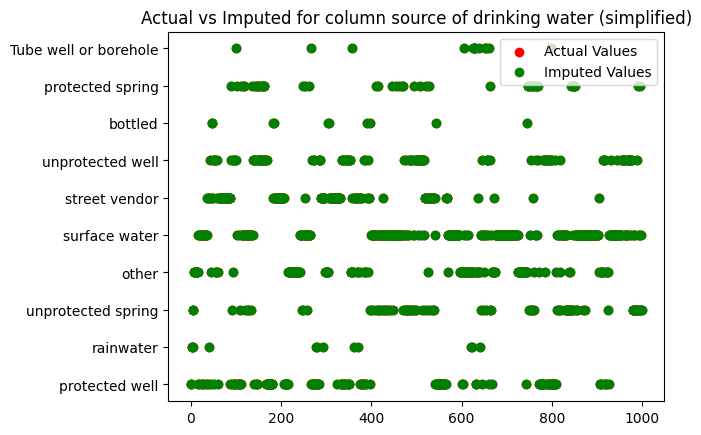

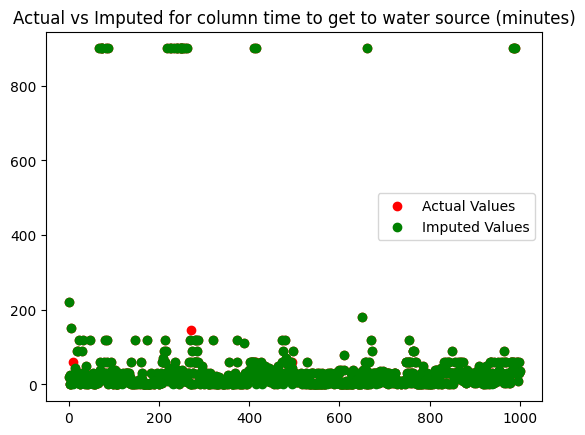

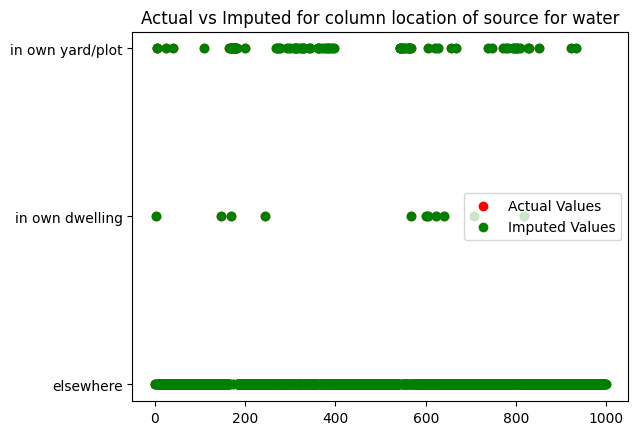

In [37]:
#plotting actual vs imputed values
for j, col in enumerate(df2.columns):
    plt.scatter([i for i in range(1000)], np.array(df2[col])[1000:2000], color="red")
    plt.scatter([i for i in range(1000)], np.array(imputed_df[col])[1000:2000], color="green")
    plt.legend(["Actual Values", "Imputed Values"])
    plt.title(f"Actual vs Imputed for column {col}")
    plt.show()

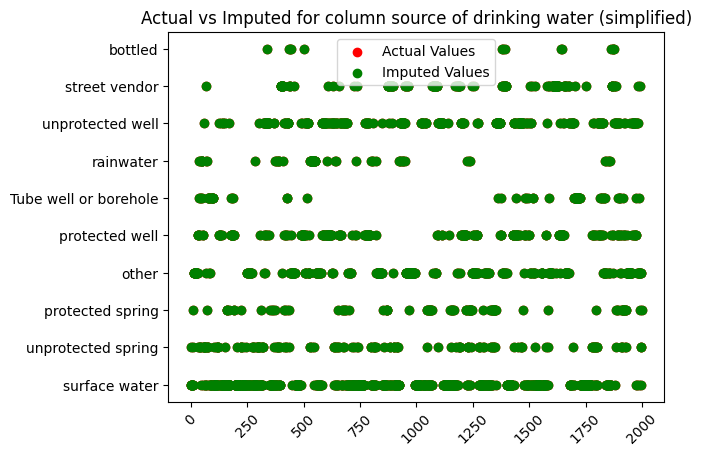

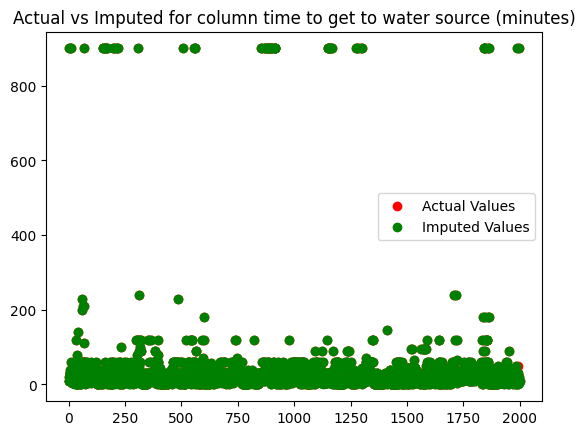

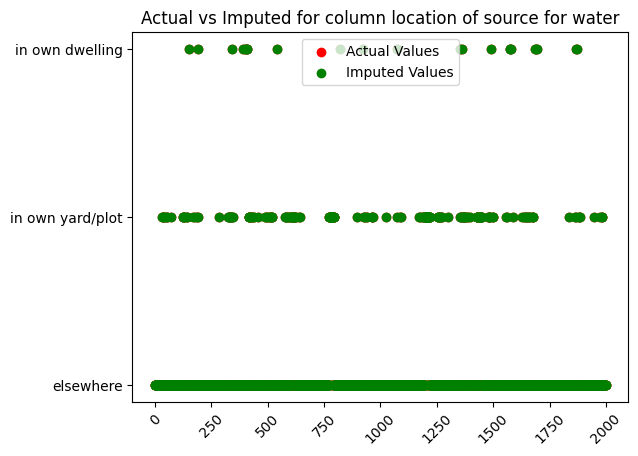

In [38]:
#plotting actual vs imputed values
for j, col in enumerate(df2.columns):
    # Increase the size of your plot
    plt.scatter([i for i in range(2000)], np.array(df2[col])[6000:8000], color="red")
    plt.scatter([i for i in range(2000)], np.array(imputed_df[col])[6000:8000], color="green")
    if df2[col].dtype == 'object':  # checking if the column is categorical
        plt.xticks(rotation=45) 
    plt.legend(["Actual Values", "Imputed Values"])
    plt.title(f"Actual vs Imputed for column {col}")
    plt.show()

In [44]:
rmse = np.sqrt(mean_squared_error(df2['time to get to water source (minutes)'], imputed_df['time to get to water source (minutes)']))
print(f"RMSE for time to get to water source (minutes): {rmse}")

RMSE for time to get to water source (minutes): 6.63536010984151


In [40]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df2['source of drinking water (simplified)'], imputed_df['source of drinking water (simplified)'])
print(f"Accuracy for source of drinking water (simplified): {accuracy}")
# similarly for 'location of source for water'
accuracy = accuracy_score(df2['location of source for water'], imputed_df['location of source for water'])
print(f"Accuracy for location of source for water: {accuracy}")

Accuracy for source of drinking water (simplified): 1.0
Accuracy for location of source for water: 1.0


In [41]:
# geting the correlation matrices
original_corr = df2.corr()
imputed_corr = imputed_df.corr()
# visualizing the correlation matrices to check if the imputed data has preserved the relationships
print(original_corr)
print(imputed_corr)

                                       time to get to water source (minutes)
time to get to water source (minutes)                                    1.0
                                       time to get to water source (minutes)
time to get to water source (minutes)                                    1.0


/tmp/ipykernel_327617/591249253.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  original_corr = df2.corr()
/tmp/ipykernel_327617/591249253.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  imputed_corr = imputed_df.corr()


In [42]:
from sklearn.metrics import mean_absolute_error
# calculating MAE for the time to get to water source (minutes)
mae_time = mean_absolute_error(df2['time to get to water source (minutes)'], imputed_df['time to get to water source (minutes)'])
print(f"MAE for time to get to water source (minutes): {mae_time}")

MAE for time to get to water source (minutes): 0.4420982748980223
